In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
import pmdarima as pm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pathlib import Path
import json
import pickle

## 1. Предобработка временного ряда

In [2]:
ROOT_DIR = Path.cwd().resolve().parent
DATA_DIR = ROOT_DIR / 'data'
MODELS_DIR = ROOT_DIR / 'models'
PREDICTIONS_DIR = ROOT_DIR / 'predictions'

y = pd.read_excel(DATA_DIR / 'data1_logs_daily.xlsx', index_col=0)

## 2. Анализ временного ряда

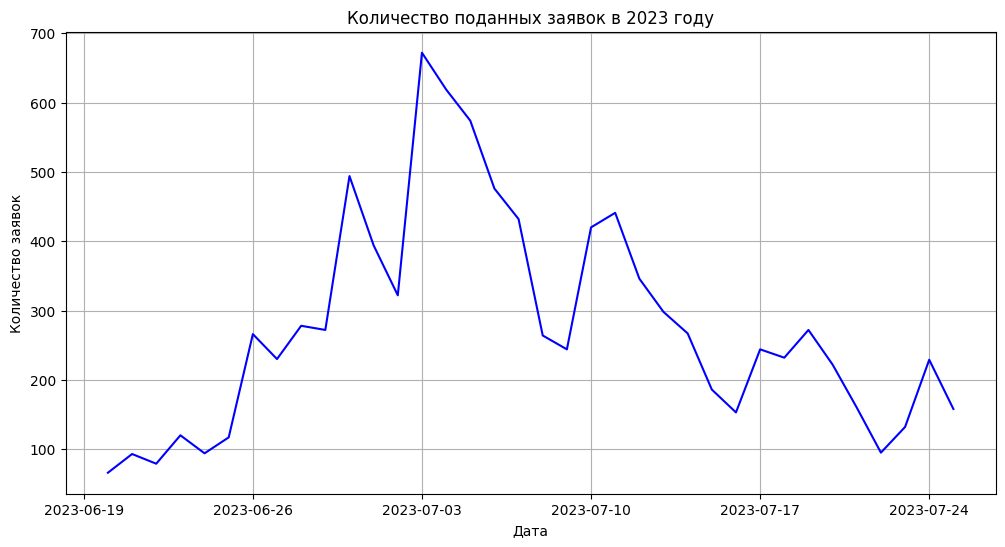

In [3]:
y2023 = y[y.index.year == 2023]

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(y2023.index, y2023, label='Поданные заявки', color='blue')

ax.set_xlabel('Дата')
ax.set_ylabel('Количество заявок')
ax.set_title('Количество поданных заявок в 2023 году')

locator = mdates.WeekdayLocator(byweekday=mdates.MO)
ax.xaxis.set_major_locator(locator)

ax.grid(True)
plt.show()

In [4]:
y_train = y[(y.index.year >= 2014) & (y.index.year <= 2023)]
y_train = y_train[(y_train.index.month == 6) & (y_train.index.day >= 20) |
                  (y_train.index.month == 7) & (y_train.index.day <= 25)]

y2024 = y[(y.index >= '2024-06-20') & (y.index <= '2024-07-25')]

### 2.1. Проверка стационарности ряда

In [20]:
# ADF-тест. H0: ряд нестационарен
adf_stat, adf_p, *_ = adfuller(y_train)
print(f"ADF p-value: {adf_p:.4f}")
# KPSS-тест. H0: ряд стационарен
kpss_stat, kpss_p, *_ = kpss(y_train)
print(f"KPSS p-value: {kpss_p:.4f}")

ADF p-value: 0.0000
KPSS p-value: 0.1000


### 2.2. Выбор начальных $p$ и $q$

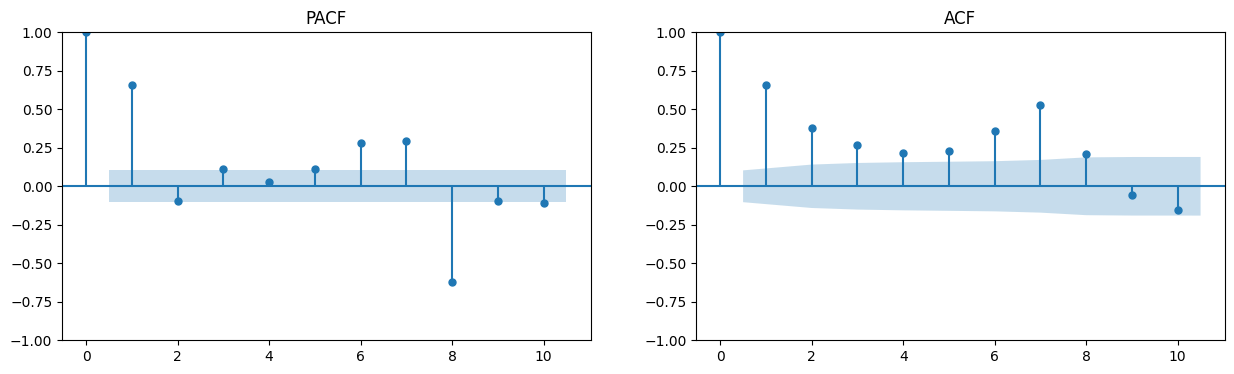

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

sm.graphics.tsa.plot_pacf(y_train, lags=10, ax=axes[0])
axes[0].set_title('PACF')

sm.graphics.tsa.plot_acf(y_train, lags=10, ax=axes[1])
axes[1].set_title('ACF')

plt.show()

p = 1, q = 1

## 3. Построение и оценка моделей

### 3.1. Без преобразований

In [7]:
model = pm.auto_arima(
    y_train,
    seasonal=True,
    m=7,
    start_p=0, max_p=3,
    start_q=0, max_q=3,
    d=None,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=4688.628, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=4875.173, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=4446.198, Time=0.36 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=4530.076, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=5200.955, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=4673.612, Time=0.02 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=4446.458, Time=0.63 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=4444.477, Time=0.54 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=4482.890, Time=0.22 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=inf, Time=1.22 sec
 ARIMA(1,0,0)(1,0,2)[7] intercept   : AIC=4415.852, Time=1.11 sec
 ARIMA(1,0,0)(0,0,2)[7] intercept   : AIC=4465.805, Time=0.64 sec
 ARIMA(1,0,0)(2,0,2)[7] intercept   : AIC=inf, Time=1.11 sec
 ARIMA(0,0,0)(1,0,2)[7] intercept   : AIC=inf, Time=1.29 sec
 ARIMA(2,0,0)(1,0,2)[7] intercept   : AIC=4435.9

In [21]:
model = sm.tsa.ARIMA(y_train, order=(1, 0, 0), seasonal_order=(1, 0, 2, 7))
model = model.fit()
print(model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  360
Model:             ARIMA(1, 0, 0)x(1, 0, [1, 2], 7)   Log Likelihood               -2200.686
Date:                              Fri, 18 Apr 2025   AIC                           4413.373
Time:                                      13:11:57   BIC                           4436.689
Sample:                                           0   HQIC                          4422.644
                                              - 360                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        255.8043    159.441      1.604      0.109     -56.695     568.304
ar.L1          0.75

- Присутствует гетероскедастичность

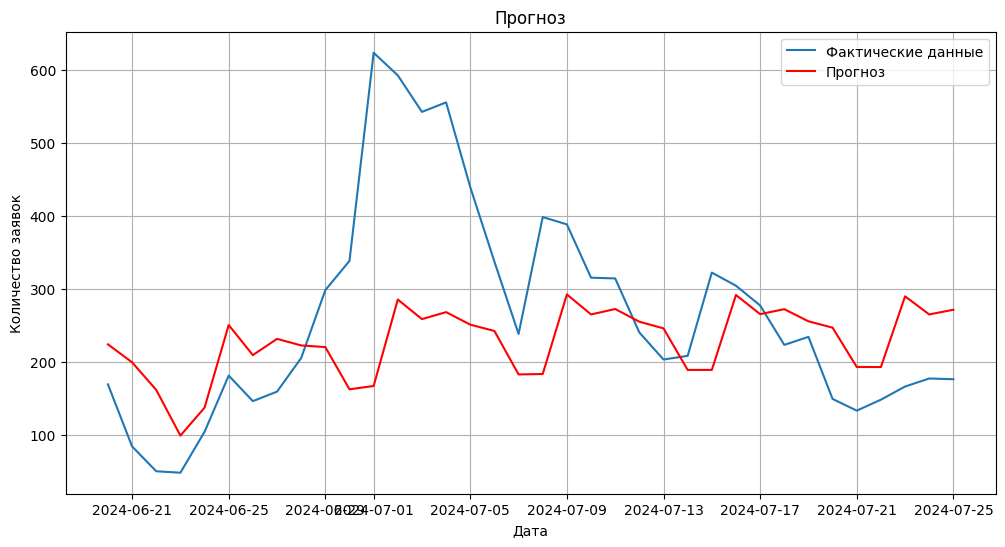

In [22]:
forecast_res = model.get_forecast(steps=36)
predicted_mean = forecast_res.predicted_mean
conf_int = forecast_res.conf_int()

plt.figure(figsize=(12,6))
plt.plot(y2024[:48].index, y2024[:48], label="Фактические данные")
plt.plot(y2024[:48].index, predicted_mean, label="Прогноз", color='red')
plt.xlabel("Дата")
plt.ylabel("Количество заявок")
plt.title("Прогноз")
plt.legend()
plt.grid()
plt.show()

In [23]:
history = y_train.copy()
predictions = []

for start in range(0, len(y2024)):
    end = min(start + 1, len(y2024))

    model = sm.tsa.SARIMAX(
        history,
        order=(1, 0, 0),
        seasonal_order=(1, 0, 2, 7),
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    forecast = model.forecast(steps=end - start)
    predictions.extend(forecast)

    new_data = y2024[start:end]
    history = pd.concat([history, new_data])

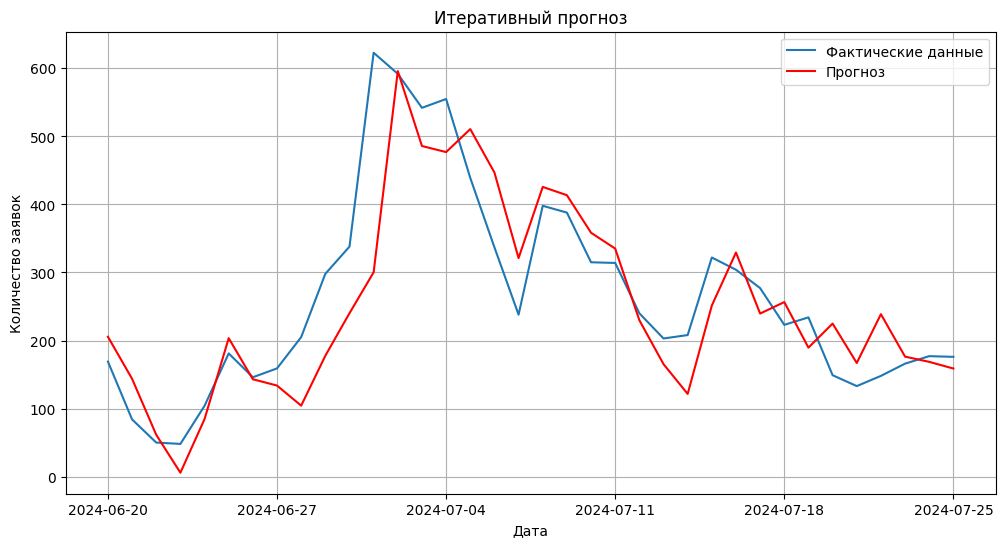

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(y2024.index, y2024, label='Фактические данные')
ax.plot(y2024.index, predictions, label='Прогноз', color='red')

ax.set_xlabel('Дата')
ax.set_ylabel('Количество заявок')
ax.set_title('Итеративный прогноз')

locator = mdates.DayLocator(interval=7)
ax.xaxis.set_major_locator(locator)

ax.legend()
ax.grid()
plt.show()

In [25]:
rmse = np.sqrt(mean_squared_error(y2024, predictions))
mae = mean_absolute_error(y2024, predictions)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

RMSE: 77.93135887267326
MAE: 54.57375537528862


### 3.2. Log-преобразование

In [26]:
y_log = np.log1p(y_train)

model_log = pm.auto_arima(
    y_log,
    seasonal=True,
    m=7,
    start_p=0, max_p=3,
    start_q=0, max_q=3,
    d=None,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=1183.892, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=1600.347, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=1110.644, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=1273.541, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=1598.347, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=1555.707, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=1100.003, Time=0.24 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=1095.900, Time=0.44 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=1096.545, Time=0.18 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=1083.182, Time=0.68 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=1095.932, Time=0.34 sec
 ARIMA(0,1,0)(2,0,2)[7] intercept   : AIC=1170.622, Time=0.66 sec
 ARIMA(2,1,0)(2,0,2)[7] intercept   : AIC=1068.095, Time=0.86 sec
 ARIMA(2,1,0)(1,0,2)[7] intercept   : AIC=1082.555, Time=0.38 sec
 ARIMA(2,1,0)(2,0,1)[7] intercept

In [27]:
print(model_log.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                  360
Model:             SARIMAX(2, 1, 0)x(2, 0, [1, 2], 7)   Log Likelihood                -526.061
Date:                                Fri, 18 Apr 2025   AIC                           1066.122
Time:                                        13:12:57   BIC                           1093.305
Sample:                                             0   HQIC                          1076.931
                                                - 360                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5783      0.031    -18.551      0.000      -0.639      -0.517
ar.

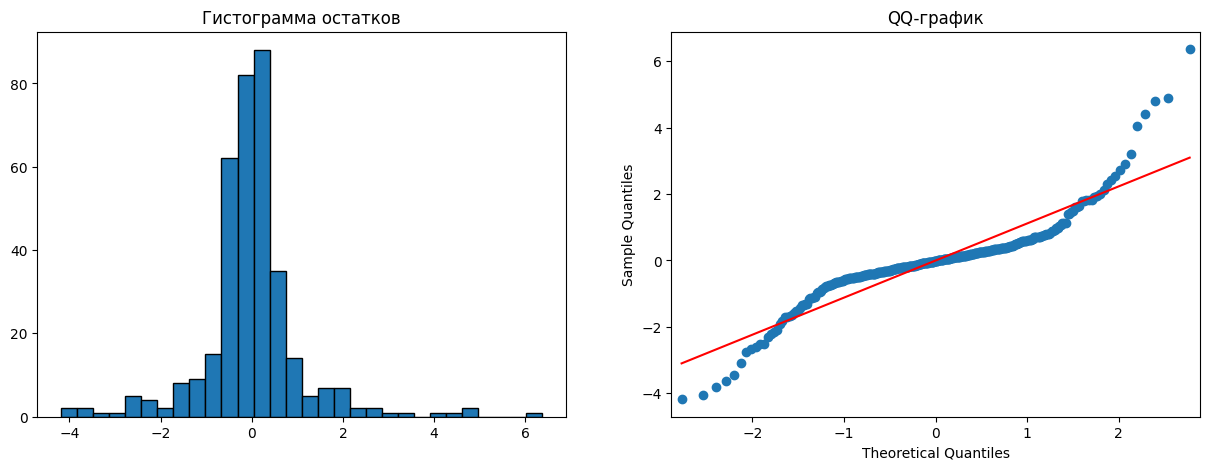

In [28]:
residuals = model_log.resid()
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].hist(residuals, bins=30, edgecolor='black')
ax[0].set_title('Гистограмма остатков')

sm.qqplot(residuals, line='s', ax=ax[1])
ax[1].set_title('QQ-график')

plt.show()

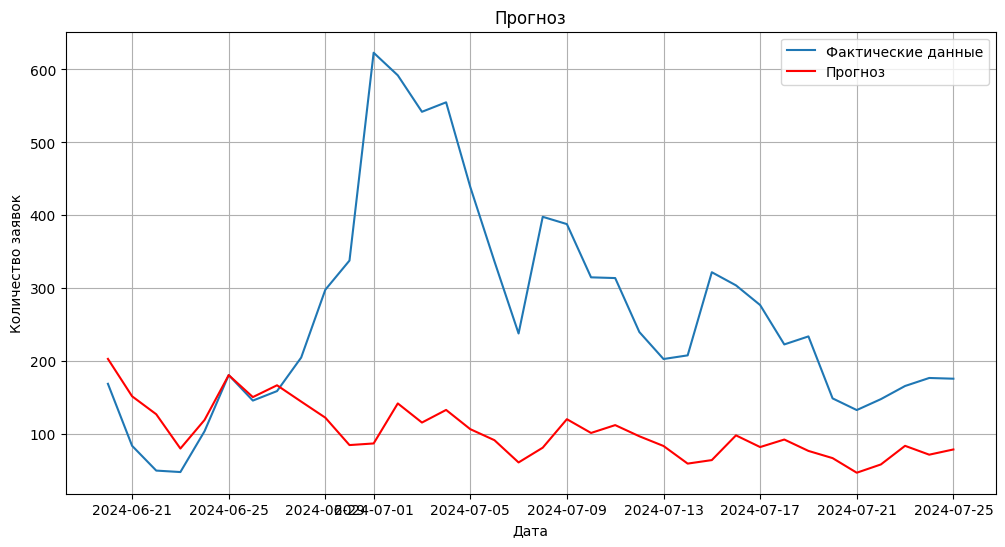

In [29]:
forecast_log = model_log.predict(n_periods=36)
forecast = np.expm1(forecast_log)

plt.figure(figsize=(12, 6))
plt.plot(y2024[:48].index, y2024[:48], label='Фактические данные')
plt.plot(y2024[:48].index, forecast, label='Прогноз', color='red')
plt.xlabel('Дата')
plt.ylabel('Количество заявок')
plt.title('Прогноз')
plt.legend()
plt.grid()
plt.show()

In [30]:
y_log_train = np.log1p(y_train)

history_log = y_log_train.copy()
predictions_log = []

for start in range(0, len(y2024)):
    end = min(start + 1, len(y2024))

    model_log = sm.tsa.SARIMAX(
        history_log,
        order=(2, 1, 0),
        seasonal_order=(2, 0, 2, 7),
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    forecast_log = model_log.forecast(steps=end - start)
    forecast = np.expm1(forecast_log)

    predictions_log.extend(forecast)

    new_data_log = np.log1p(y2024[start:end])
    history_log = pd.concat([history_log, new_data_log])

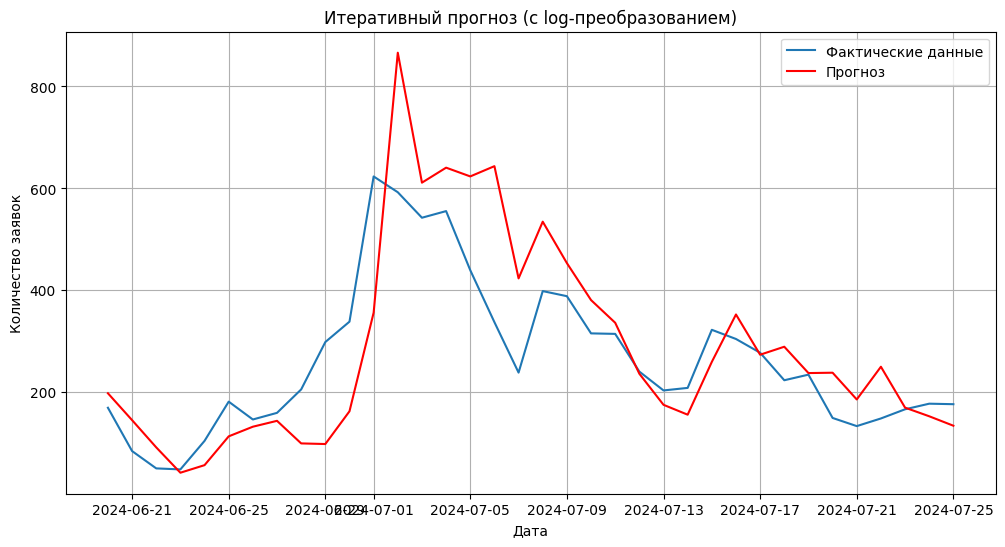

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(y2024.index, y2024, label='Фактические данные')
plt.plot(y2024.index, predictions_log, label='Прогноз', color='red')
plt.xlabel('Дата')
plt.ylabel('Количество заявок')
plt.title('Итеративный прогноз (с log-преобразованием)')
plt.legend()
plt.grid()
plt.show()

In [32]:
rmse = np.sqrt(mean_squared_error(y2024, predictions_log))
mae = mean_absolute_error(y2024, predictions_log)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

RMSE: 115.61628723138682
MAE: 83.47200294854909


In [34]:
# Остановимся на модели без преобразований данных
with open(MODELS_DIR / 'arima_daily_model.pkl', 'wb') as file:
    pickle.dump(model, file)

with open(PREDICTIONS_DIR / 'arima_daily_predictions.json', 'w') as file:
    json.dump(predictions, file)

## 4. Дополнительный анализ

### 4.1. Сравнение подневной и агрегированной почасовой моделей

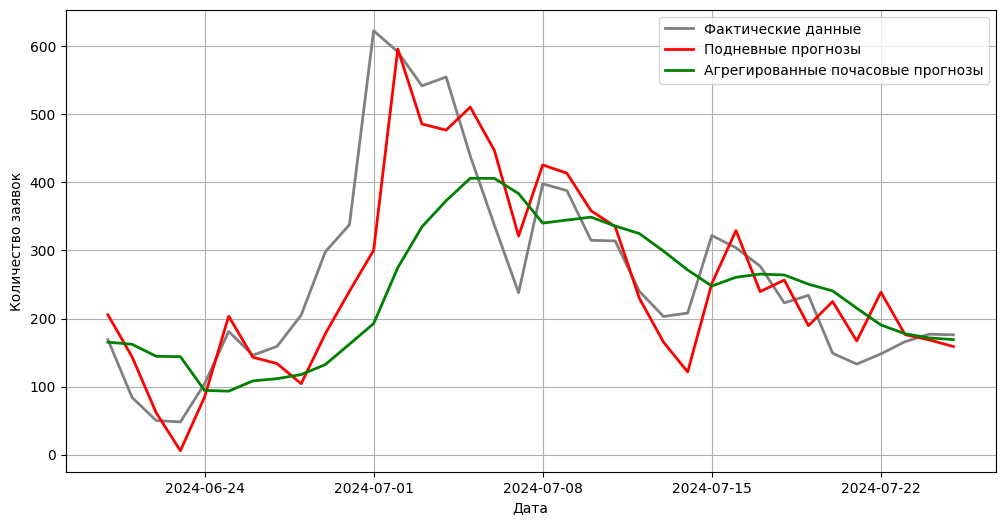

In [ ]:
with open(PREDICTIONS_DIR / 'arima_daily_predictions.json', 'r', encoding='utf-8') as file:
    daily_predictions = json.load(file)

with open(PREDICTIONS_DIR / 'arima_hourly_predictions.json', 'r', encoding='utf-8') as file:
    hourly_predictions = json.load(file)

n_hours = 24
aggregated_h_predictions = [
    sum(hourly_predictions[i:i+n_hours])
    for i in range(0, len(hourly_predictions), n_hours)
]

daily_predictions = np.array(daily_predictions)
aggregated_hourly_predictions = np.array(aggregated_h_predictions)
actual_values = y2024.values

dates_2024 = y2024.index

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(dates_2024, actual_values, label='Фактические данные', color='gray', linewidth=2)
ax.plot(dates_2024, daily_predictions, label='Подневные прогнозы', color='red', linewidth=2)
ax.plot(dates_2024, aggregated_hourly_predictions, label='Агрегированные почасовые прогнозы', color='green', linewidth=2)

ax.set_xlabel('Дата')
ax.set_ylabel('Количество заявок')

locator = mdates.WeekdayLocator(byweekday=mdates.MO)
ax.xaxis.set_major_locator(locator)

ax.legend()
ax.grid(True)
plt.show()

### 4.2. Визуализация итеративного построения прогноза

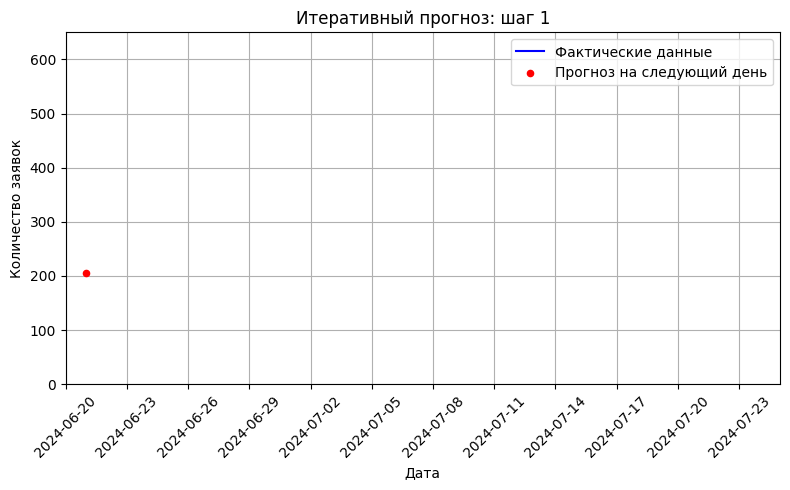

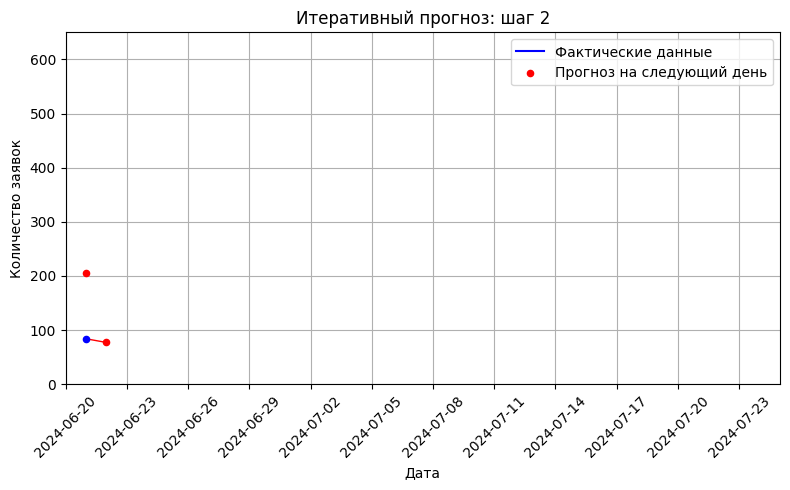

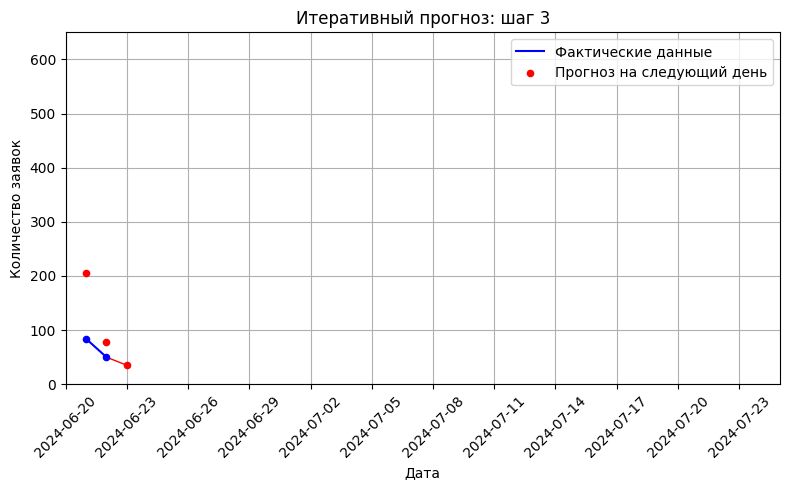

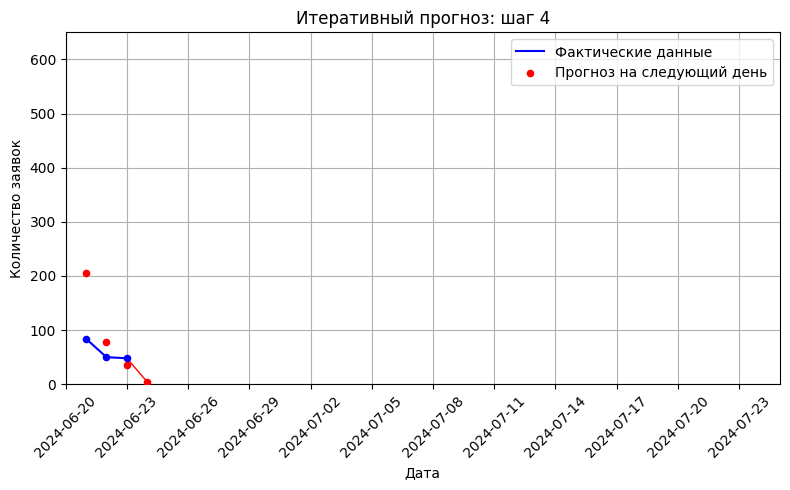

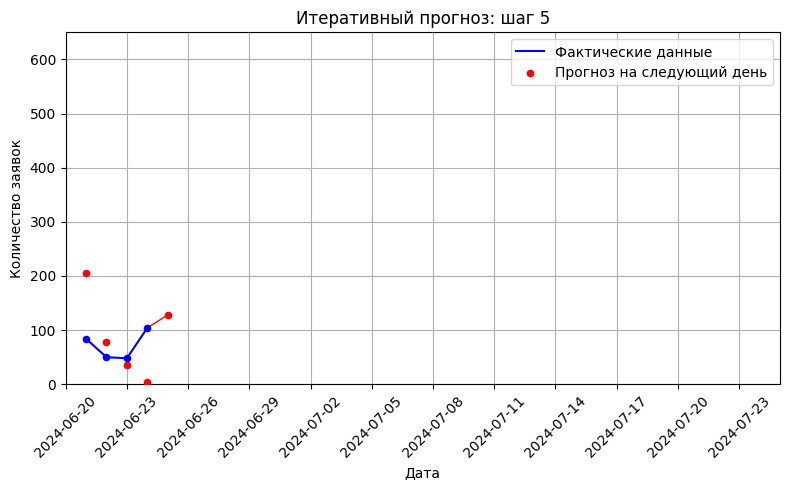

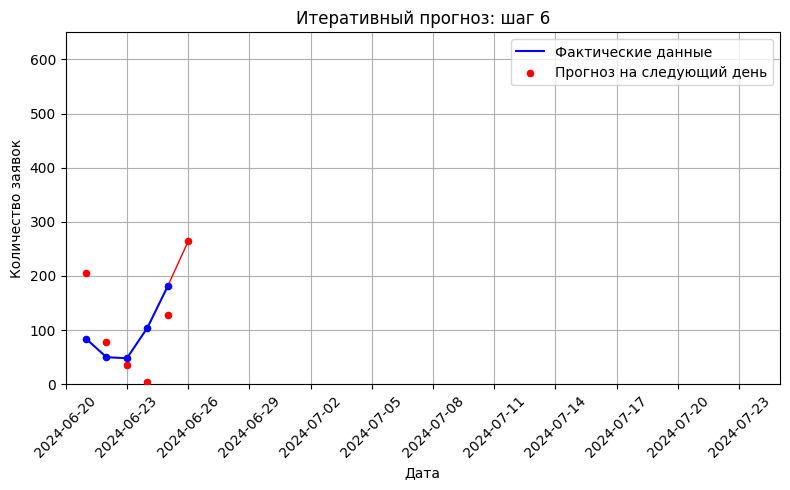

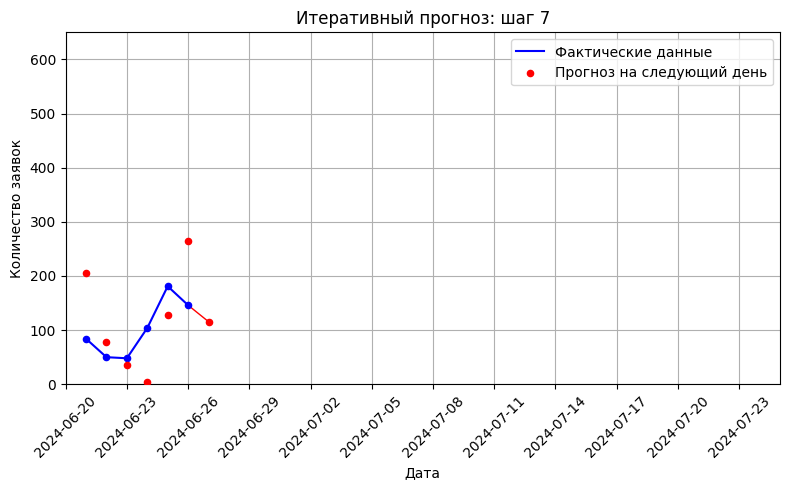

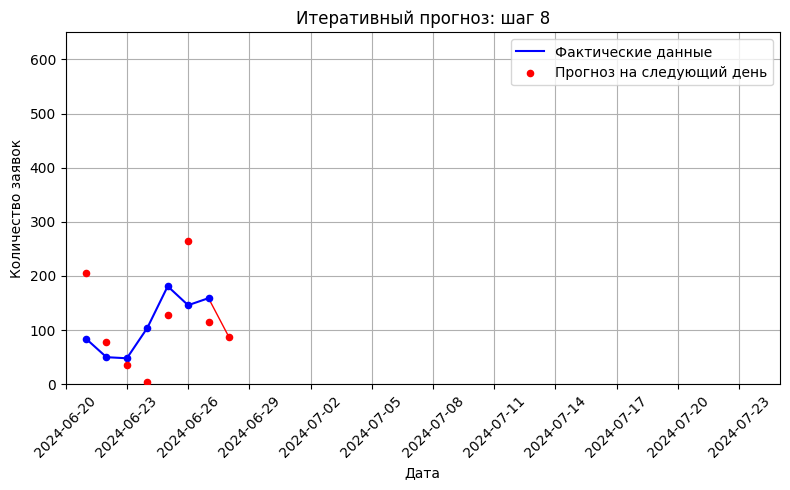

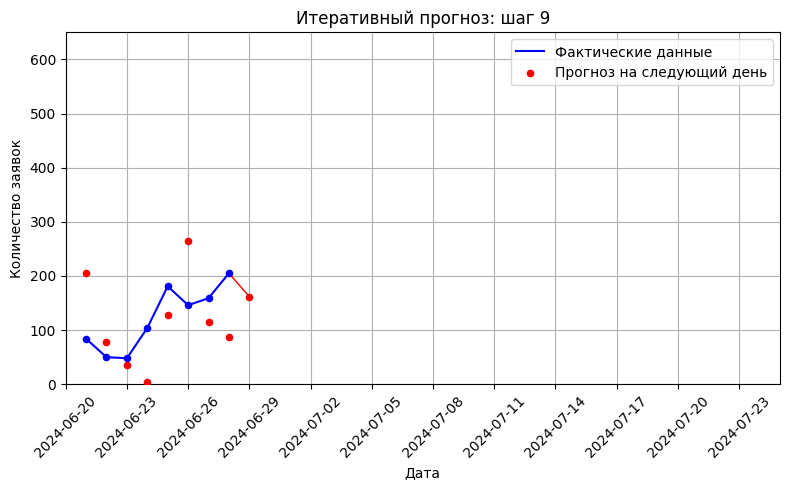

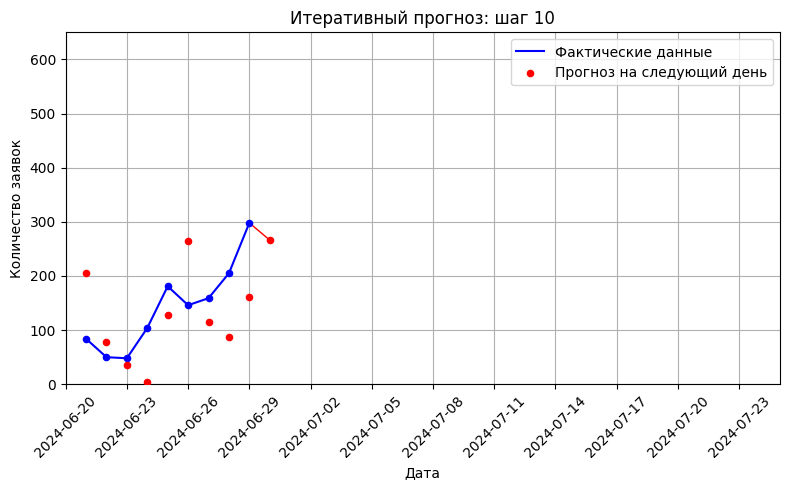

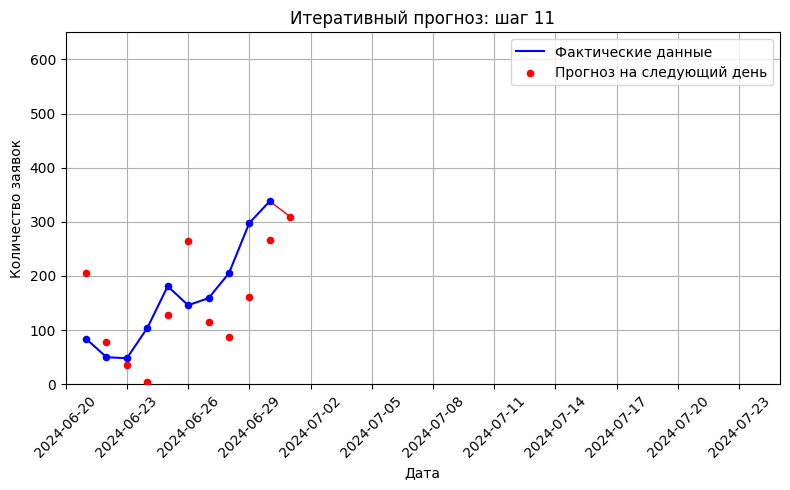

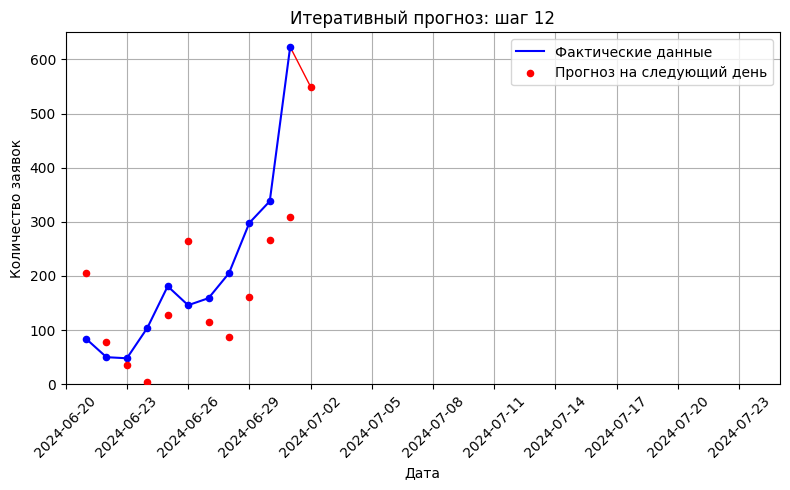

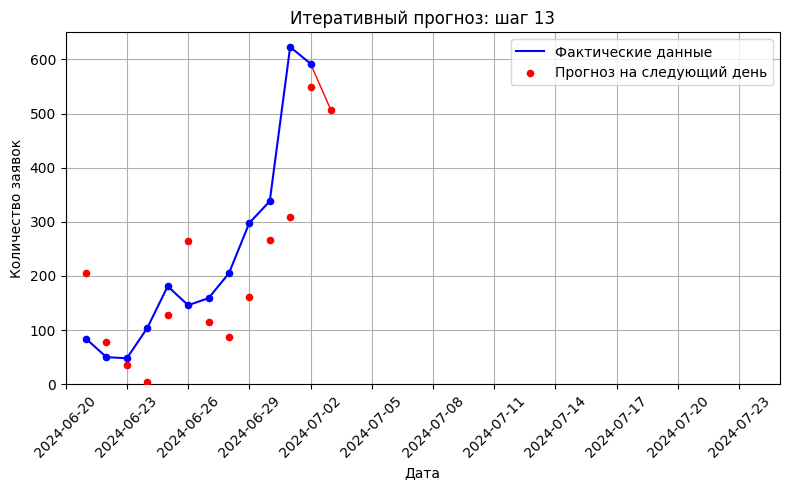

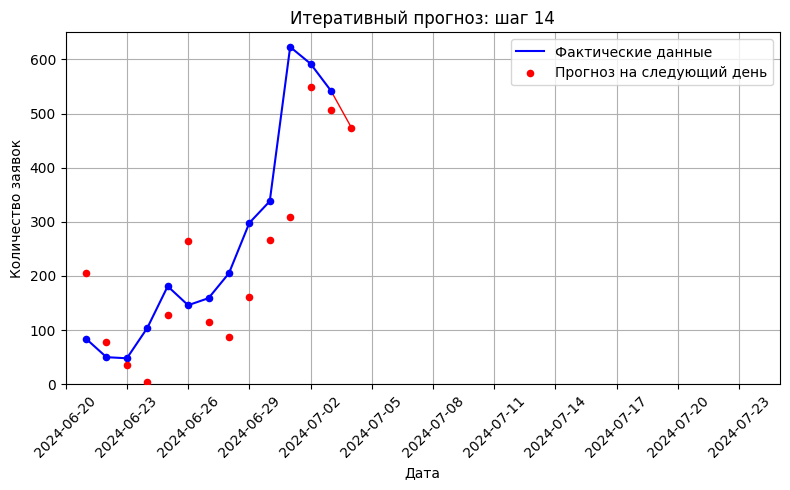

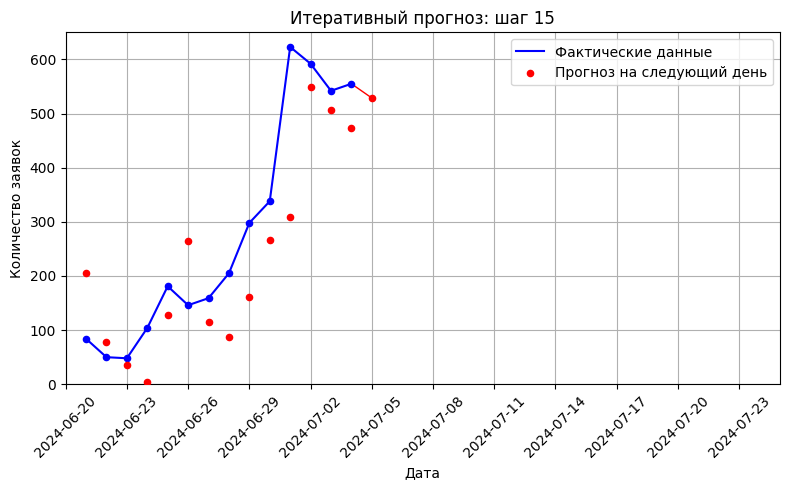

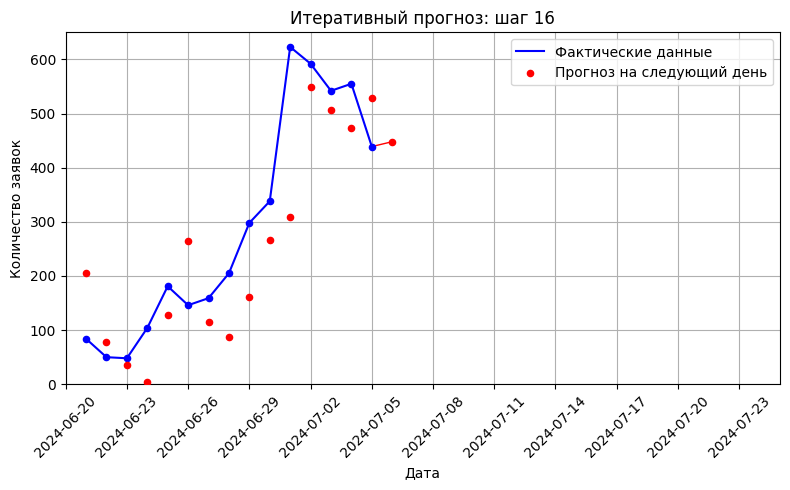

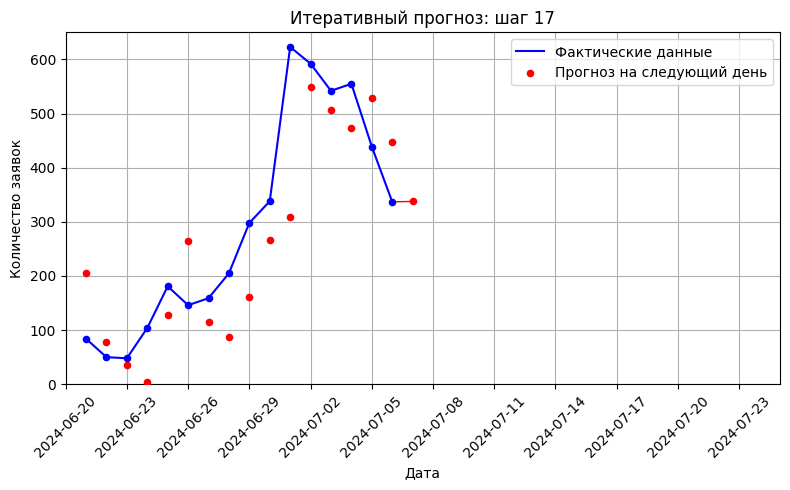

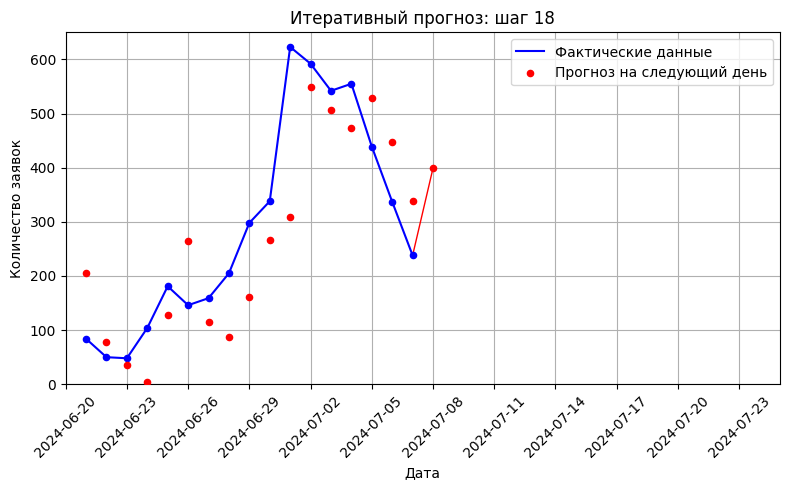

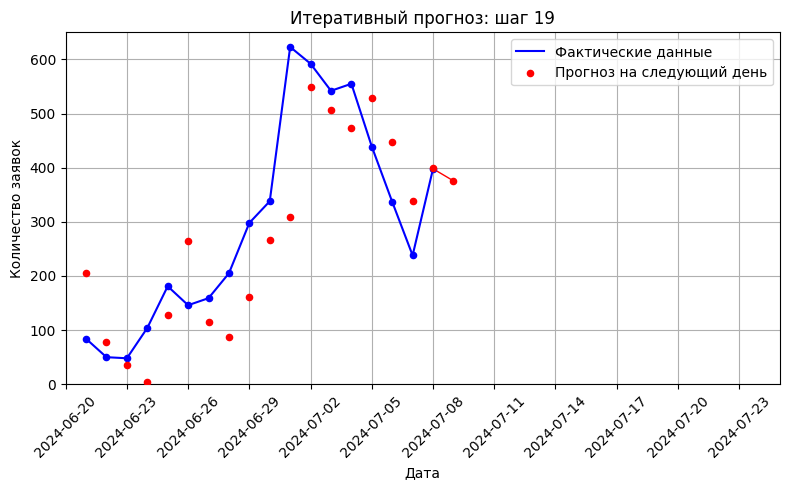

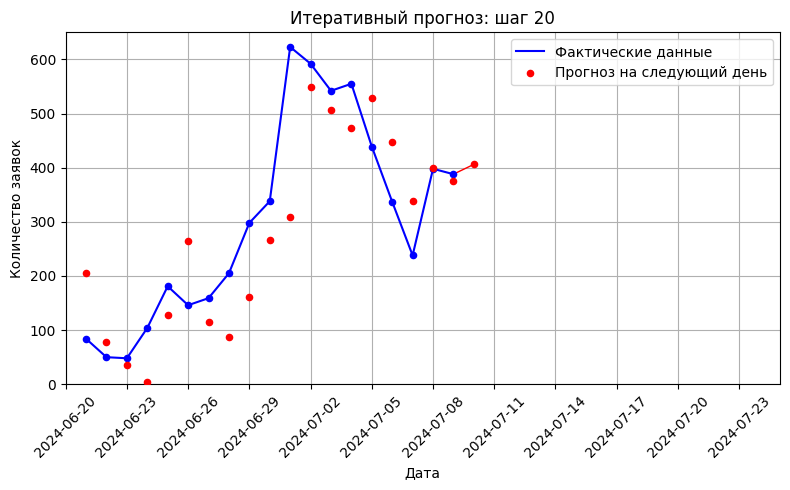

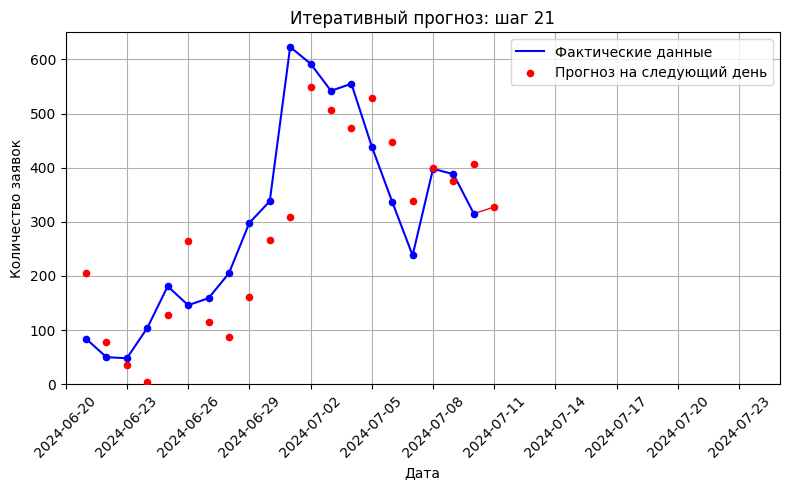

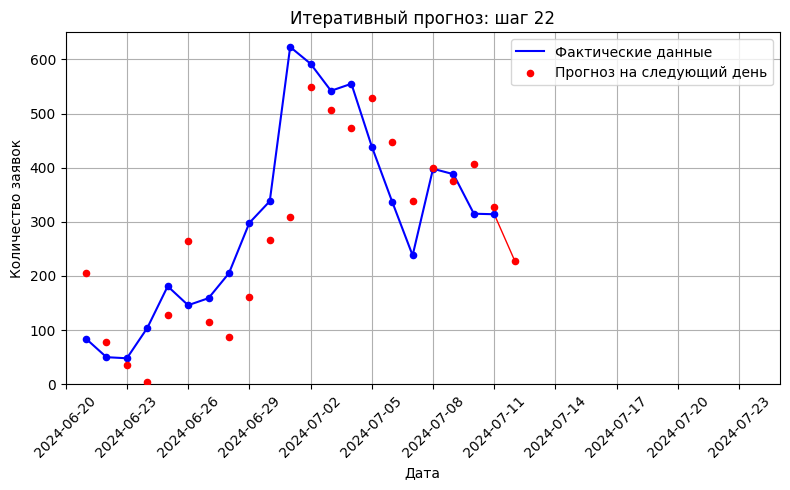

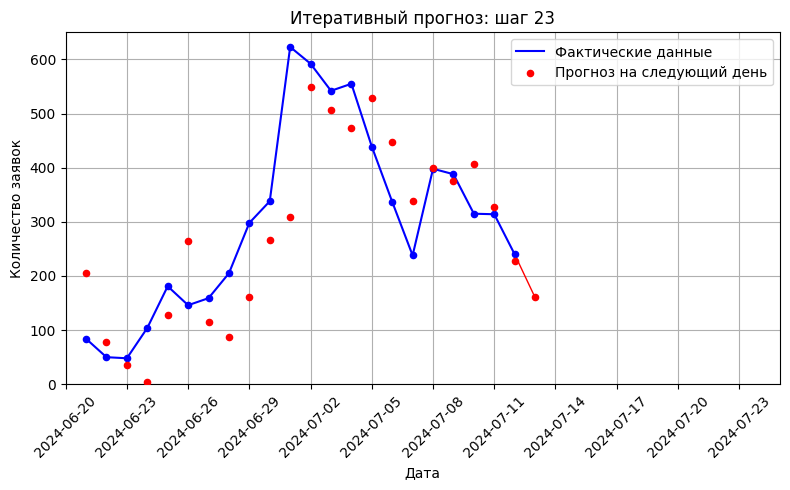

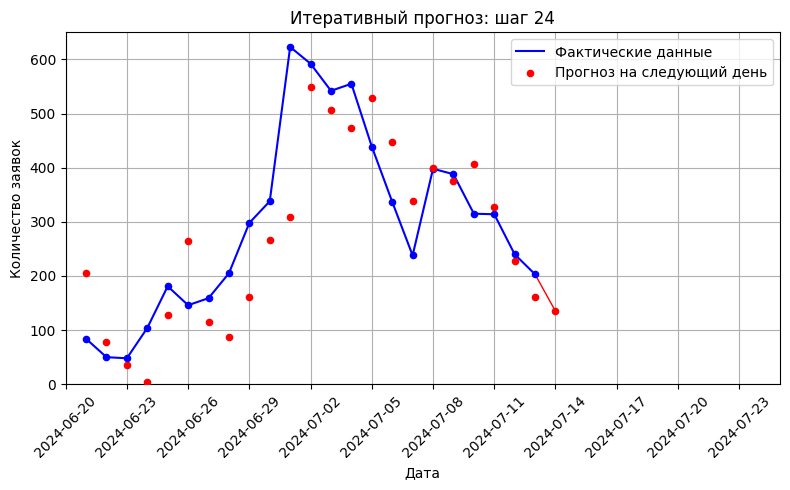

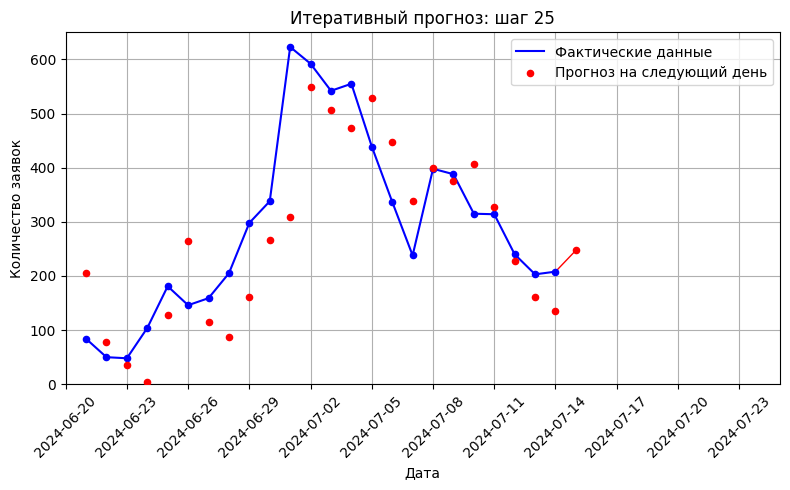

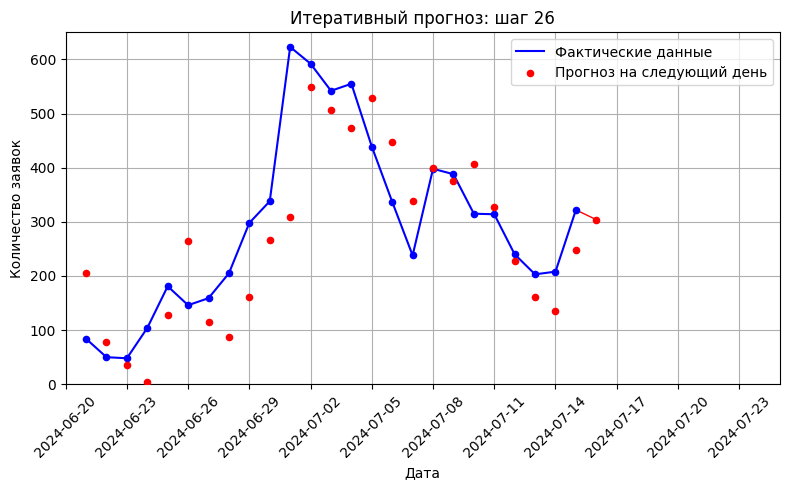

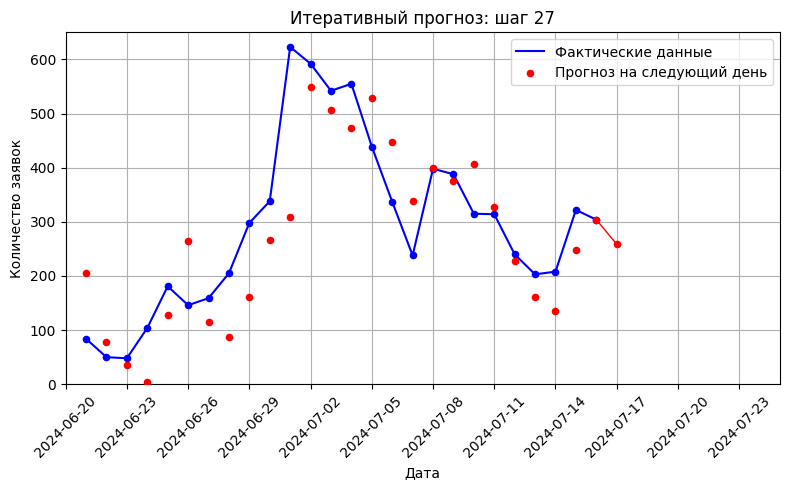

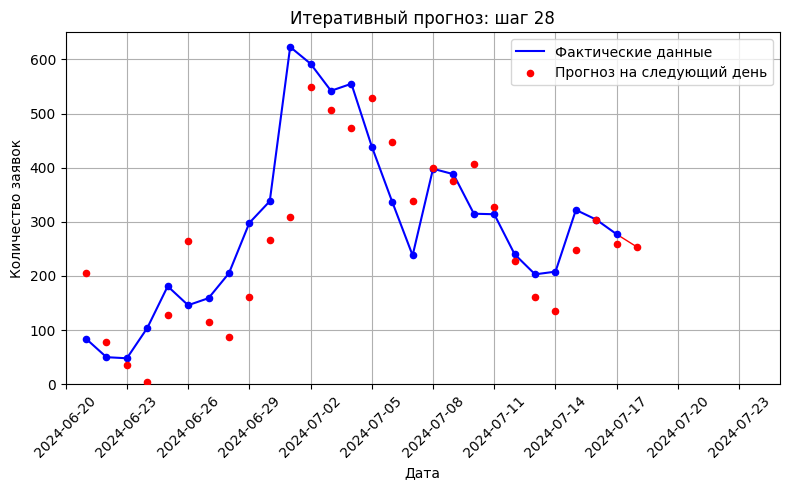

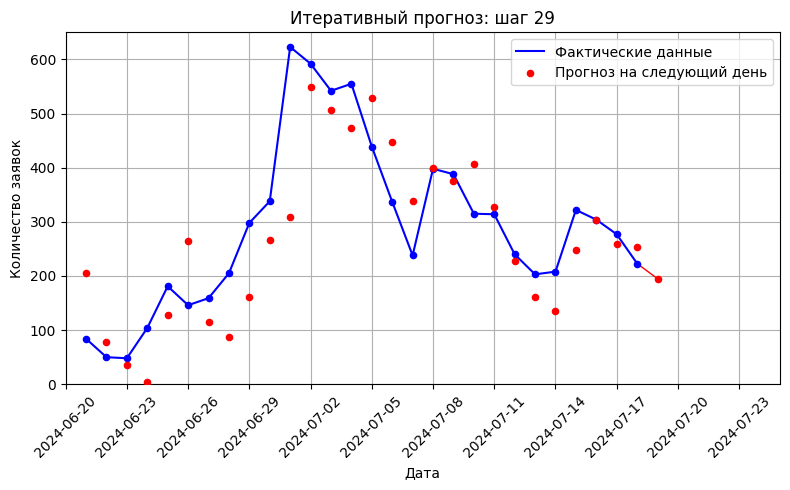

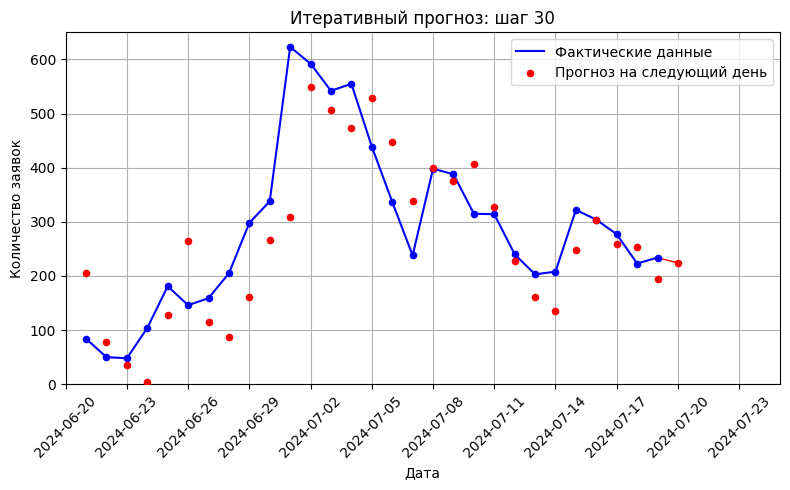

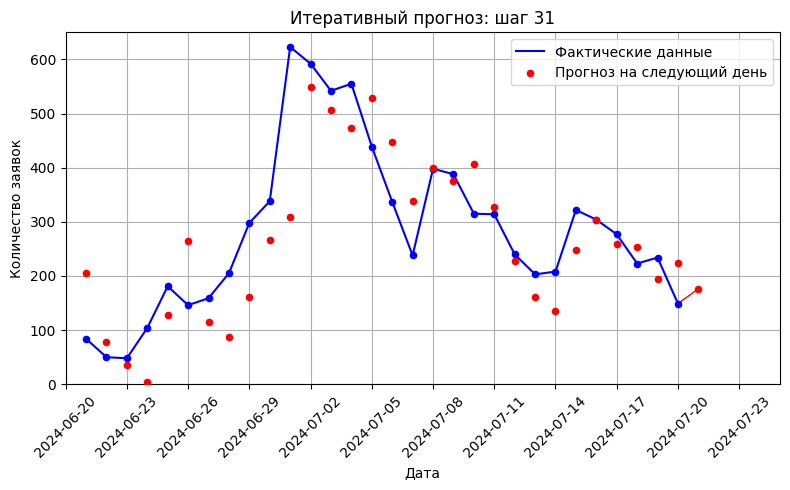

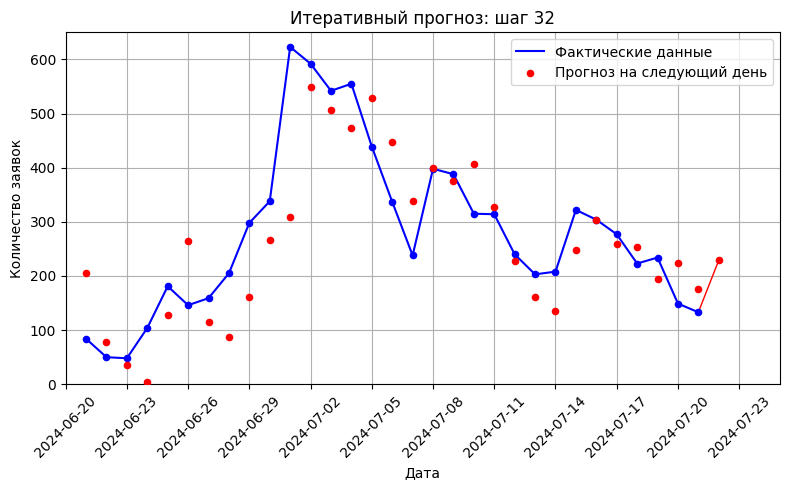

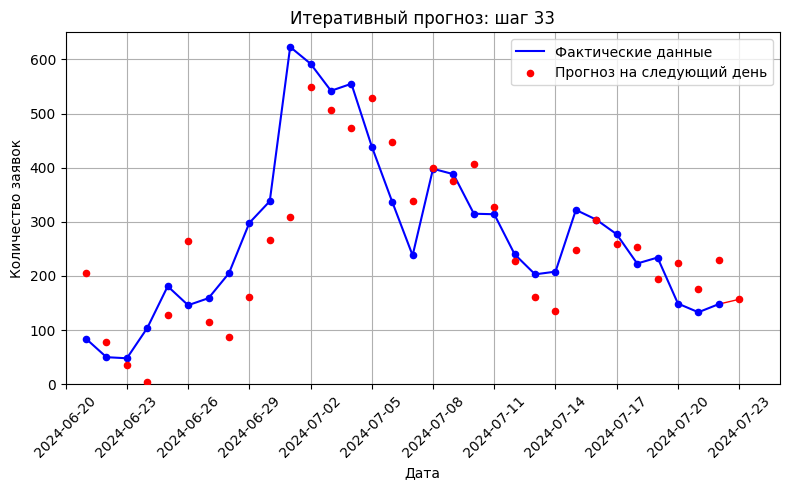

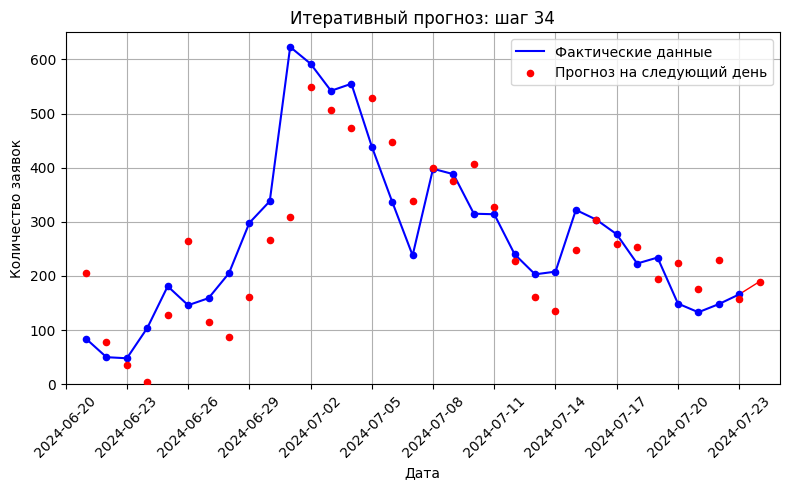

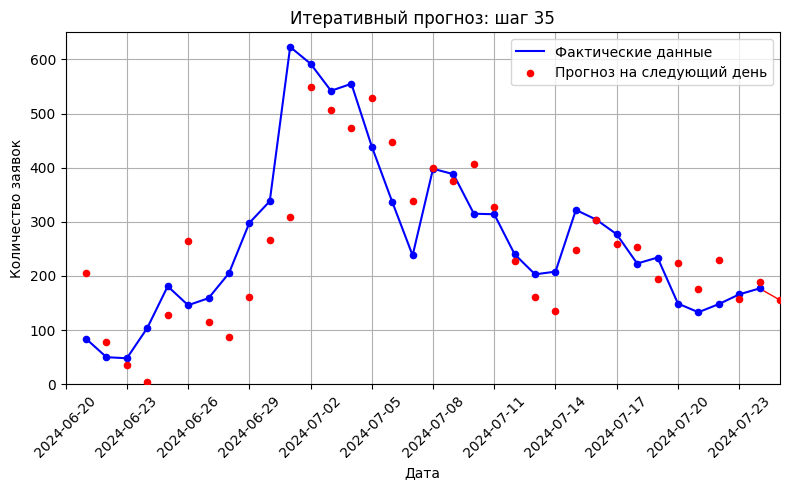

In [27]:
history = y_train.copy()
predictions = []

x_start = pd.Timestamp('2024-06-20')
x_end = pd.Timestamp('2024-07-25')

for i in range(1, len(y2024)):
    model = sm.tsa.SARIMAX(history,
                           order=(1, 0, 0),
                           seasonal_order=(1, 0, 2, 7),
                           enforce_stationarity=False,
                           enforce_invertibility=False).fit(disp=False)

    forecast = model.forecast(steps=1)
    forecast_value = float(forecast.iloc[0])
    predictions.append(forecast_value)
    
    fig, ax = plt.subplots(figsize=(8, 5))
    
    history_plot = history[history.index >= x_start]
    ax.plot(history_plot.index, history_plot.values, label='Фактические данные', color='blue')
    ax.scatter(history_plot.index, history_plot.values, color='blue', s=20, zorder=3)
    
    forecast_dates = y2024.index[1:i+1]
    ax.scatter(forecast_dates, predictions, color='red', s=20, zorder=5, label='Прогноз на следующий день')
    
    if len(history_plot) > 0:
        last_date = history_plot.index[-1]
        last_value = float(history_plot.values[-1])
        ax.plot([last_date, y2024.index[i]], [last_value, forecast_value],
                color='red', linewidth=1)
    
    ax.set_xlim(x_start, x_end)
    ax.set_ylim(0, 650)
    
    ax.set_xlabel('Дата')
    ax.set_ylabel('Количество заявок')
    ax.set_title(f'Итеративный прогноз: шаг {i}')
    ax.legend()
    ax.grid(True)
    
    locator = mdates.DayLocator(interval=3)
    ax.xaxis.set_major_locator(locator)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    new_data = y2024.iloc[[i]]
    history = pd.concat([history, new_data])